# Model Training and Evaluation Methods

### Evaluate predictions

In [115]:
def evaluate_predictions(y_true, y_pred, plot_start_index=-500):
    print(f'\n\n{StartBold}Predictions Evaluation:{EndBold}\n')
    y_p = np.asarray(my_scaler_tv.inverse_transform(y_pred.reshape(-1,1))).ravel()
    n_predictions = len(y_p)
    y = np.asarray(y_true[-n_predictions:]).ravel()
    print('Predictions:', n_predictions)
    mae = float(tf.metrics.mean_absolute_error(y, y_p))
    mae_scaled = my_scaler_tv.transform(np.array([[mae]]))
    print(f'MAE: {mae:.2f} ({mae_scaled[0, 0]:.4f})')

    plt.subplots(figsize=(15,2))
    plt.plot(y[plot_start_index:], marker='.', label='true')
    plt.plot(y_p[plot_start_index:], marker='.', label='predicted')
    plt.legend()
    plt.show()

### The models
The required window

Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']

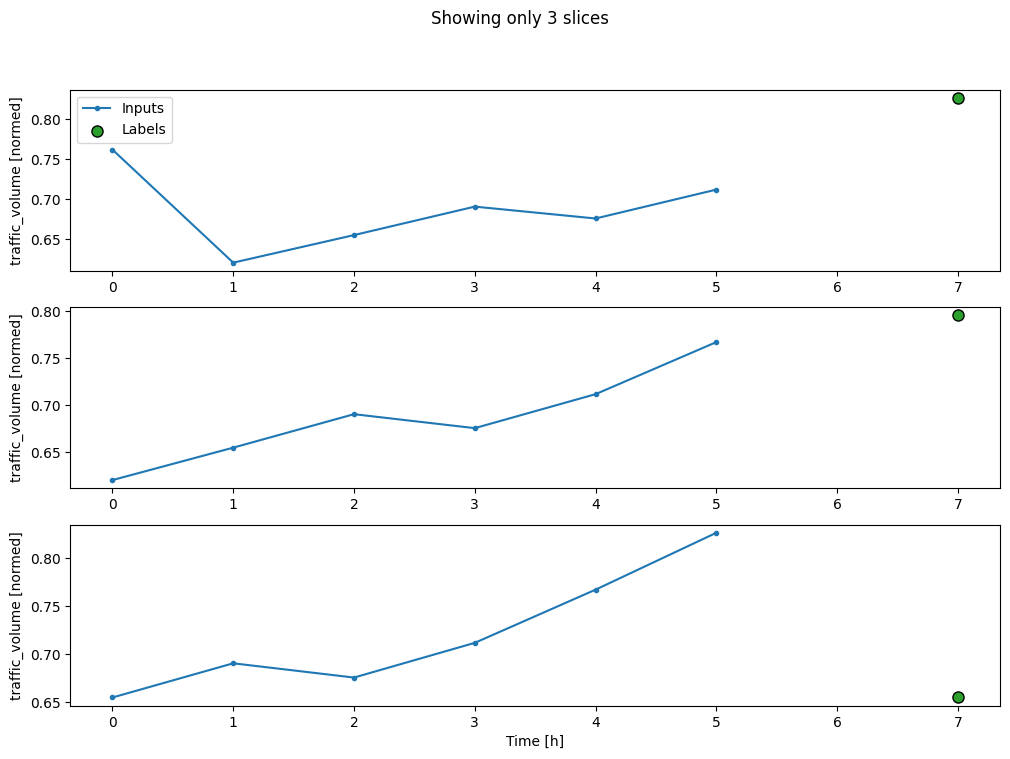

In [116]:
INPUT_WIDTH = 6
OUT_STEPS = 1
SHIFT = 2
base_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )

base_window.plot()
base_window

### Baseline Models

In [123]:
multi_val_performance = {}
multi_performance = {}
our_models = {}

our_log = {
    'multi_val_performance':multi_val_performance,
    'multi_performance':multi_performance,
    'our_models':our_models
    }

I set all the models to converge into a single output value, which is the traffic volume at the 8th day based on 6 days input of the full features.


### RNN



Training vs. Validation:



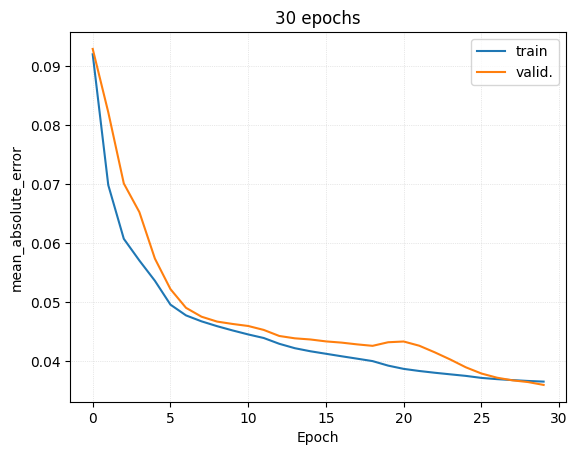



Validation Scores:

261/261 - 1s - 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0359


In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_label = 'LSTM'
current_window = base_window  # Replace with the appropriate window variable

lstm_model = Sequential([
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    Dense(OUT_STEPS)
])

history = compile_and_fit(lstm_model, current_window,
                          model_label=model_label, log_dict=our_log)

# Our LTMS Models
I created another Window Gen to experiment with the batch size in my models

In [127]:
our_window1 = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )
print("our_window1", our_window1)

# I created another WindowGen to experiment with the batch size in my models
our_window2 = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=64
                               )
print("our_window2", our_window2)

our_window1 Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']
our_window2 Total window size: 8 = 6+(1+1)
Batch size: 64
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']


### Custom  LTMS Model 



Training vs. Validation:



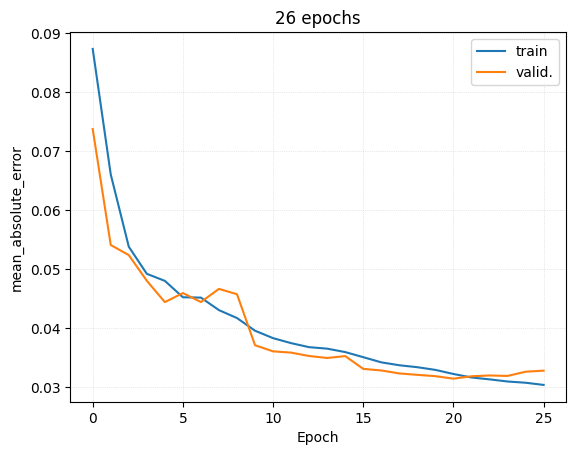



Validation Scores:

261/261 - 8s - 30ms/step - loss: 0.0023 - mean_absolute_error: 0.0314


In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_label = 'Custom LSTM'
current_window = our_window1

our_lstm_model = Sequential([
    LSTM(512, return_sequences=True),
    LSTM(512, return_sequences=False),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(our_lstm_model, current_window,
                          model_label=model_label, log_dict=our_log)

In [129]:
our_lstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 6, 512)              │       1,105,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,192,837 (42.70 MB)

 Trainable params: 3,730,945 (14.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,461,892 (28.46 MB)

### Bidirectional LSTM Model 



Training vs. Validation:



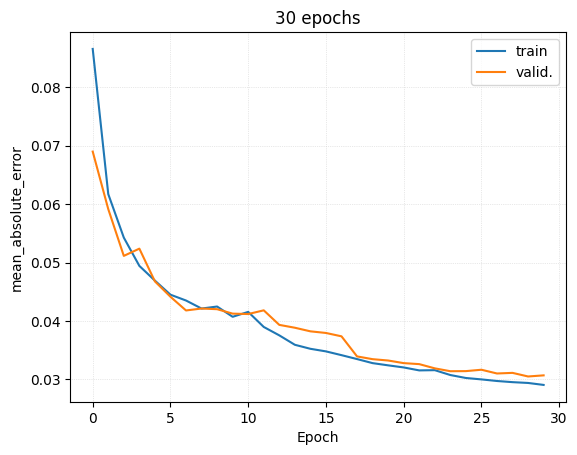



Validation Scores:

261/261 - 12s - 46ms/step - loss: 0.0021 - mean_absolute_error: 0.0305
CPU times: total: 12h 38min 53s
Wall time: 2h 10min 53s


In [130]:
%%time
model_label = 'Bidirectional LSTM'
current_window = our_window1

forward_layer = LSTM(512, return_sequences=True)
backward_layer = LSTM(512, return_sequences=True, go_backwards=True)
 
our_lstm_model = tf.keras.Sequential([
    Bidirectional(forward_layer, backward_layer=backward_layer),
    Bidirectional(LSTM(512, return_sequences=False, stateful=False)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(our_lstm_model, current_window,
                          model_label=model_label, log_dict=our_log,
                          )

In [132]:
our_lstm_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 6, 1024)             │       2,211,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1024)                │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,886,085 (106.38 MB)

 Trainable params: 9,295,361 (35.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,590,724 (70.92 MB)